# TO DO
- user flow analysis
- how many users purchase how often which products etc.
- reduce product_id to fewer, check what can be grouped
- check for splitting up catagory_code or not.., maybe low volume products can be category code three or sth..
- think about taking out outliers (Tukey's Method) but probably not needed

# Libraries

In [1]:
# Basic Libraries
import pandas as pd
import os
import sys
import numpy as np
import warnings

# Visualisation Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
import seaborn as sns
import plotly.graph_objs as go

# Admin Libraries
sys.path.append(os.path.abspath(".."))
from utils import helper_functions as hf

# Settings
# pd.set_option('display.max_row', None) # display all rows
pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings

#Color Palette
color1='#4a86e8'
color2='#ffd966'
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1,color2])
custom_cmap2 =  [color1,color2]

# Opening the data

In [2]:
filepath = '../data/events_cleaned.csv' 
df = pd.read_csv(filepath) 
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,last_view_before_purchase,last_view_before_cart,already_in_cart
0,2020-10-29 11:28:35+00:00,view,4101974,2144415939364389423,electronics.clocks,honor,76.48,1515915625353226922,7qejzWzHlR,0,0,0
1,2020-10-06 06:30:32+00:00,view,3506650,2144415935673401802,Unknown,kester,28.98,1515915625353230067,ikPKHkuRhA,0,0,0
2,2020-11-09 08:52:51+00:00,view,124883,2144415924424278172,electronics.audio.acoustic,logitech,23.90,1515915625353230683,dn9FkZ11dA,0,0,0
3,2020-11-09 09:08:53+00:00,view,125325,2144415924424278172,electronics.audio.acoustic,logitech,23.90,1515915625353230683,dn9FkZ11dA,0,0,0
4,2020-11-18 10:51:35+00:00,view,254763,2144415924424278172,electronics.audio.acoustic,creative,74.24,1515915625353230683,5qXvZIBV2W,0,0,0


In [3]:
# Convert the 'event_time' column to datetime format
# This is important for time series analysis and any time-based filtering
df['event_time'] = pd.to_datetime(df['event_time'])

# Explorative data analysis

In [5]:
views_that_dont_lead_to_purchases = view_df[view_df["last_view_before_purchase"] == 0]
views_that_lead_to_purchases = view_df[view_df["last_view_before_purchase"] == 1]

# Time

In [6]:
# Extract the full hour from the event_time column and create a new column time_of_day
df['time_of_day'] = df['event_time'].dt.strftime('%H:00:00')
# creting a day of week column
df['day_of_week'] = df['event_time'].dt.day_name()
# Creating a month column in order to check distribution of events per month
df['month'] = df['event_time'].dt.to_period('M') 
# The timeframe of the dataframe
print(f"The dataframe time spans from {df.event_time.min()} and ends with {df.event_time.max()}")

The dataframe time spans from 2020-09-24 11:57:06+00:00 and ends with 2021-02-28 23:59:09+00:00


In [7]:
# The number of events per month and event type
df.groupby(['month', 'event_type']).size()

month    event_type
2020-09  cart            1412
         purchase        1007
         view           25640
2020-10  cart            8728
         purchase        6276
         view          146414
2020-11  cart           10435
         purchase        7574
         view          170082
2020-12  cart            9342
         purchase        6529
         view          136719
2021-01  cart           12695
         purchase        8315
         view          166431
2021-02  cart           11420
         purchase        7642
         view          147813
dtype: int64

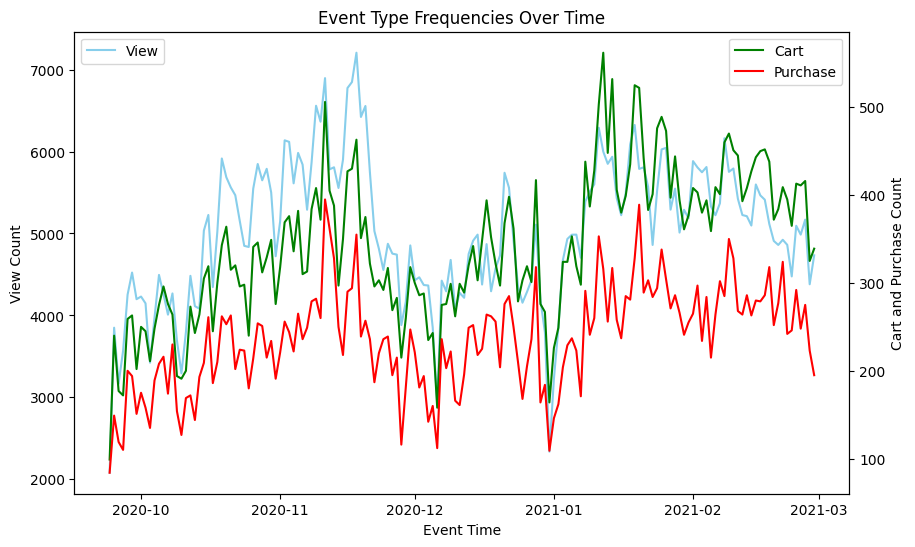

In [8]:
# Set event_time as the index
df.set_index('event_time', inplace=True)

# Resample and count occurrences for each event type
view_counts = df[df['event_type'] == 'view'].resample('D').size()
cart_counts = df[df['event_type'] == 'cart'].resample('D').size()
purchase_counts = df[df['event_type'] == 'purchase'].resample('D').size()

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot views on first y-axis
ax1.plot(view_counts.index, view_counts.values, label='View', color='skyblue')
ax1.set_xlabel('Event Time')
ax1.set_ylabel('View Count')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Create a second y-axis for cart and purchase
ax2 = ax1.twinx()
ax2.plot(cart_counts.index, cart_counts.values, label='Cart', color='green')
ax2.plot(purchase_counts.index, purchase_counts.values, label='Purchase', color='red')
ax2.set_ylabel('Cart and Purchase Count')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('Event Type Frequencies Over Time')
plt.savefig("../images/event_type_over_time.png")
plt.show()

# Purchasers vs. Non-Purchaser Views

In [24]:
def create_distribution_plot(num, plot_type, cap=1000):
    # Define subplot configuration
    nrows, ncols = 5, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,20))
    axes = axes.flatten()

    # Constants for plot styling
    color2 = 'skyblue'  # define color2 for distribution plot where it was not originally defined
    color1 = 'cyan'     # define color1 for outlier plots where it was not originally defined

    for i, ax in enumerate(axes):
        if i >= len(num.columns):  # Avoiding empty plots
            ax.set_visible(False)
            continue
            
        # Plot according to the given plot type
        column_data = num.iloc[:, i].dropna()
        ax.set_title(num.columns[i], fontsize=15)

        if plot_type == 'distribution':
            filtered_data = column_data[column_data <= cap]  # Cap values at 1000
            ax.hist(filtered_data, bins=1000, color=color2, edgecolor='black')          
        elif plot_type == 'outliers':
            ax.boxplot(
                column_data, vert=False, patch_artist=True,
                boxprops={'facecolor': color1, 'color': 'black'}, 
                medianprops={'color': 'yellow'},
                whiskerprops={'color': 'black'},
                capprops={'color': 'black'},
                flierprops={'marker': 'o', 'color': 'red', 'markersize': 5}
            )
            ax.tick_params(axis='x', labelsize=14)

    plt.tight_layout()
    plt.show()

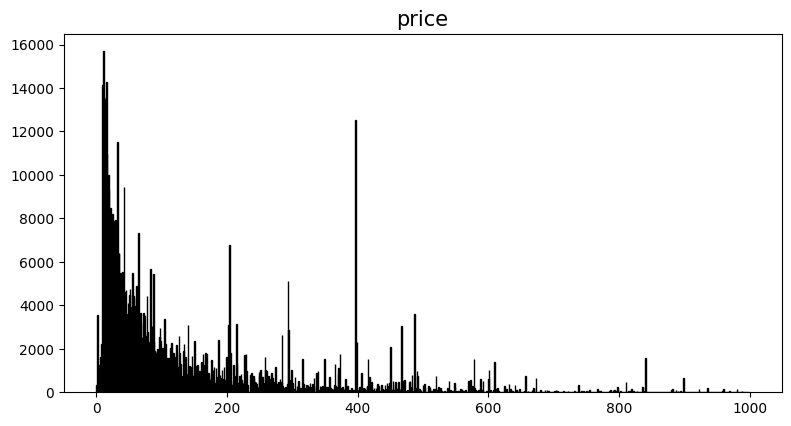

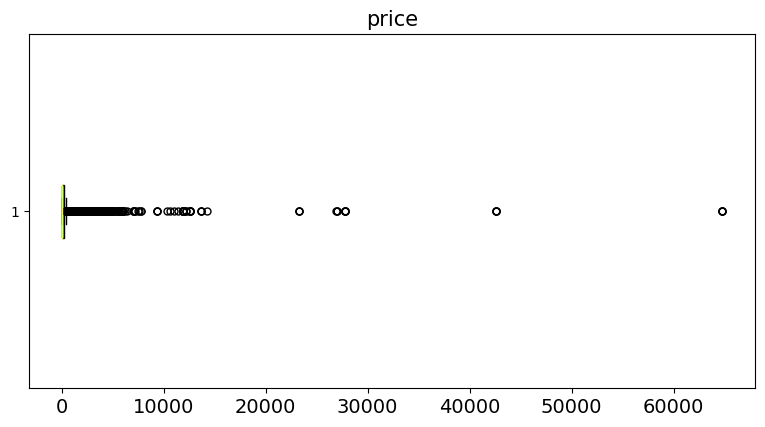

In [25]:
create_distribution_plot(hf.create_subset(views_that_dont_lead_to_purchases, ['price']), 'distribution', 1000)
create_distribution_plot(hf.create_subset(views_that_dont_lead_to_purchases, ['price']), 'outliers')

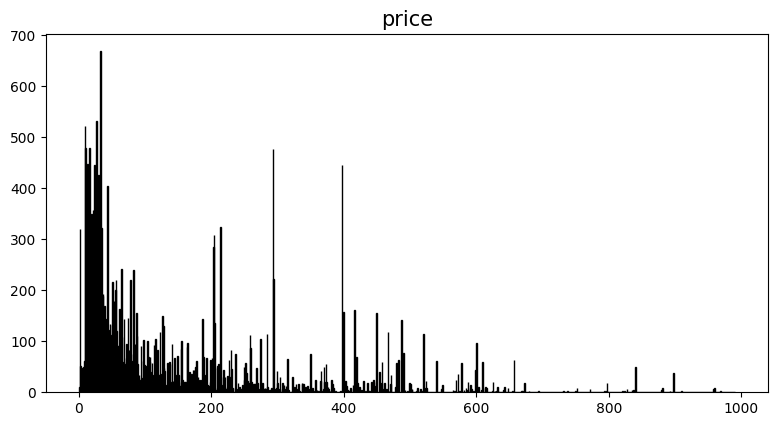

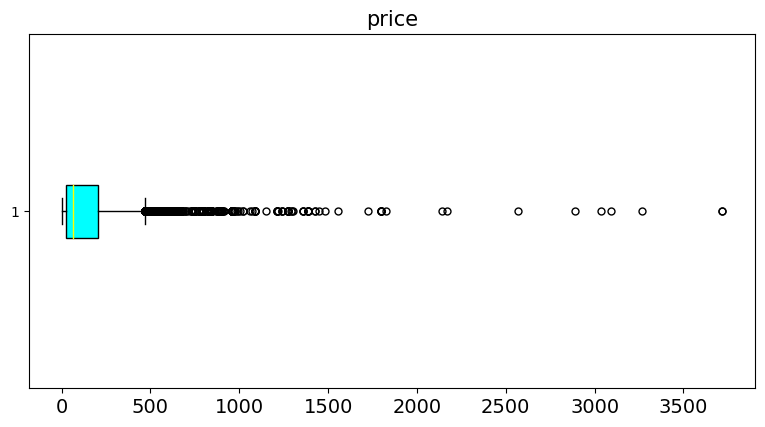

In [27]:
create_distribution_plot(hf.create_subset(views_that_lead_to_purchases, ['price']), 'distribution')
create_distribution_plot(hf.create_subset(views_that_lead_to_purchases, ['price']), 'outliers')

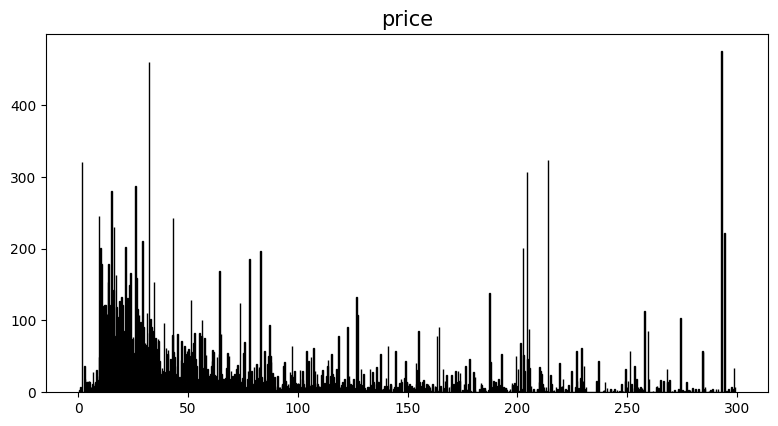

In [28]:
create_distribution_plot(hf.create_subset(views_that_lead_to_purchases, ['price']), 'distribution', 300)

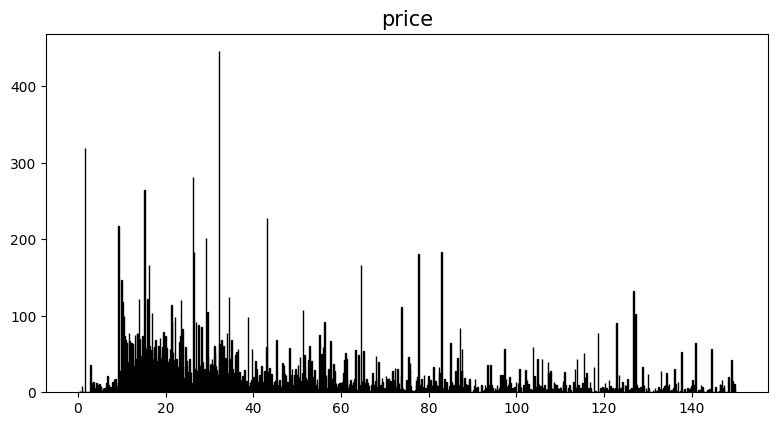

In [29]:
create_distribution_plot(hf.create_subset(views_that_lead_to_purchases, ['price']), 'distribution', 150)

In [33]:
# Define price bins and labels
price_bins = [0, 10, 50, 100, 200, 500, 1000, float('inf')]
price_labels = ['0-10', '10-50','50-100', '100-200', '200-500', '500-1000', '1000+']

# Create a new column for discretized price
df['price_range'] = pd.cut(df['price'], bins=price_bins, labels=price_labels, right=False)

# Display the first few rows to verify
df[['price', 'price_range']].head()

,price,price_range
event_time,,
2020-10-29 11:28:35+00:00,76.48,50-100
2020-10-06 06:30:32+00:00,28.98,10-50
2020-11-09 08:52:51+00:00,23.90,10-50
2020-11-09 09:08:53+00:00,23.90,10-50
2020-11-18 10:51:35+00:00,74.24,50-100


In [34]:
# Filter the DataFrame to include only 'view' events
view_df = df[df['event_type'] == 'view']

In [35]:
view_df

,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,last_view_before_purchase,last_view_before_cart,already_in_cart,time_of_day,day_of_week,month,price_range
event_time,,,,,,,,,,,,,,,
2020-10-29 11:28:35+00:00,view,4101974,2144415939364389423,electronics.clocks,honor,76.48,1515915625353226922,7qejzWzHlR,0,0,0,11:00:00,Thursday,2020-10,50-100
2020-10-06 06:30:32+00:00,view,3506650,2144415935673401802,Unknown,kester,28.98,1515915625353230067,ikPKHkuRhA,0,0,0,06:00:00,Tuesday,2020-10,10-50
2020-11-09 08:52:51+00:00,view,124883,2144415924424278172,electronics.audio.acoustic,logitech,23.90,1515915625353230683,dn9FkZ11dA,0,0,0,08:00:00,Monday,2020-11,10-50
2020-11-09 09:08:53+00:00,view,125325,2144415924424278172,electronics.audio.acoustic,logitech,23.90,1515915625353230683,dn9FkZ11dA,0,0,0,09:00:00,Monday,2020-11,10-50
2020-11-18 10:51:35+00:00,view,254763,2144415924424278172,electronics.audio.acoustic,creative,74.24,1515915625353230683,5qXvZIBV2W,0,0,0,10:00:00,Wednesday,2020-11,50-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 23:54:18+00:00,view,3829355,2144415922528452715,electronics.telephone,Unknown,32.22,1515915625611023671,wZb7gP1zgN,0,0,0,23:00:00,Sunday,2021-02,10-50
2021-02-28 23:55:01+00:00,view,953226,2144415927553229037,Unknown,Unknown,219.94,1515915625611023730,FRLqIttxKU,0,0,0,23:00:00,Sunday,2021-02,200-500
2021-02-28 23:58:05+00:00,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma,0,0,0,23:00:00,Sunday,2021-02,50-100


In [37]:
# create df for ML
hf.create_subset(df, ['product_id', 'category_id', 'category_code', 'brand', 'last_view_before_cart', 'already_in_cart', 'time_of_day', 'day_of_week', 'month', 'price_range', 'last_view_before_purchase']).to_csv('../data/events_ml.csv', index=False)